# Hyperparameter search - model selection

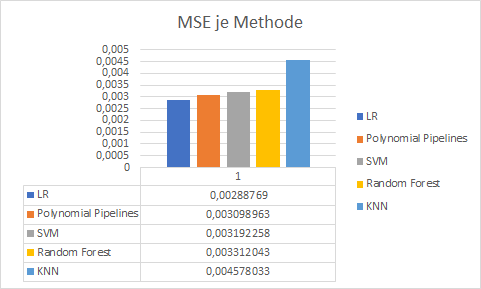

we tried 5 different methods to predict the values from the testing phase - the graph shows the mean squared error (MSE) of 
each method


In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
import datetime as dt
import pandas_datareader as web



from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression


# Import the data from yahoo for test and training

gather data from yahoo via direct access


In [2]:
index = '^STOXX50E' #index name in yahoo

#first and last day of trainings set
start_train = dt.datetime(2007,7,1)
end_train = dt.datetime(2017,7,1)

#data for training
data_train = web.DataReader(index, 'yahoo',start_train,end_train) 

#start and endday of the test set
start_test = dt.datetime(2017,7,2)
end_test = dt.datetime(2021,5,1)

#data for testing
data_test = web.DataReader(index, 'yahoo',start_test,end_test)

#data_train.tail()

# Manipulate the training data to fit to your use case

with the command data_train['Close'] we only get the closing prices 
with this, we use the function pct_change which calculates the percentage change between the current and a prior element 
-> in this case the closing price 

In [3]:
data_train['Change'] = data_train['Close'].pct_change()

to delete the datetime index we use the function reset_index so that the date is an individual comulmn and the rest of the 
data does not directly depend on the date anymore

In [4]:
data_train.reset_index(inplace=True)

In [5]:
#split the date down to month+year
data_train['mdate'] = data_train['Date'].dt.to_period('M')

adding +1 to the percentual change to get the 'real' change of the stockprice

In [6]:
data_train['ProdChange'] = data_train['Change'] +1

group the data by month and year 

In [7]:
group = data_train.groupby(['mdate'])

get additionally the corresponding month in an own column

In [8]:
data_train['Month'] = data_train['Date'].dt.month

get the monthly change by grouping the change by month+year, get the overall change fpr each month and delete 1 to get back to the change value 

In [9]:
data_train['mChange'] = group['ProdChange'].transform(np.product) -1

push the months with each change in an own dataset and transfer the data into another data set to get rid of duplicates with the method drop_duplicates

In [10]:
monthlyChange = data_train[['Month','mChange']]
monthlyChangeSingle = monthlyChange.drop_duplicates()

In [11]:
#monthlyChangeSingle

## visualize the data for the training data to have a first overview

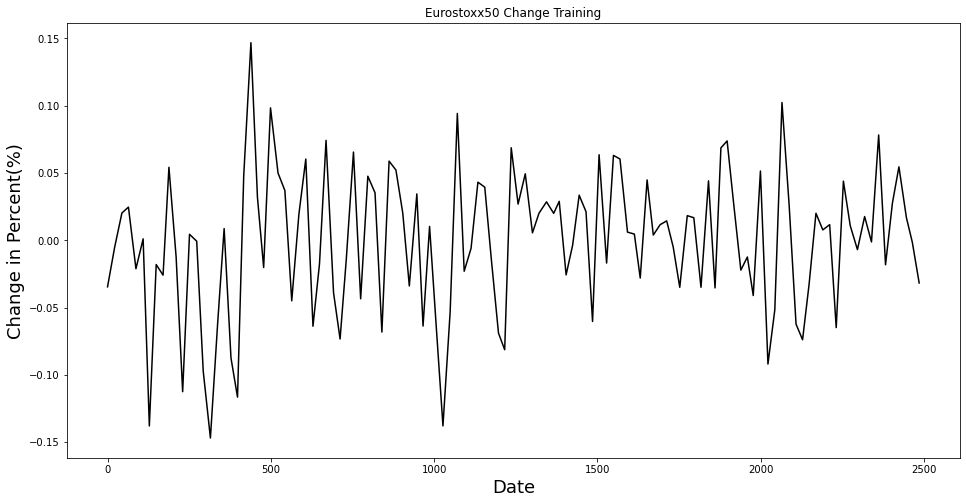

In [12]:
plt.figure(figsize=(16,8))
plt.title('Eurostoxx50 Change Training')
plt.plot(monthlyChangeSingle['mChange'], color = 'black')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Change in Percent(%)',fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()

# do the entire process above again with the test data in order to compare

In [13]:
#do the same with testing data

data_test['Change'] = data_test['Close'].pct_change()
data_test.reset_index(inplace=True)
data_test['mdate'] = data_test['Date'].dt.to_period('M')
data_test['ProdChange'] = data_test['Change'] +1
data_test['Month'] = data_test['Date'].dt.month
group_testing = data_test.groupby(['mdate'])
data_test['mChange'] = group_testing['ProdChange'].transform(np.product) -1

monthlyChange_testing = data_test[['Month','mChange']]
monthlyChange_testing = monthlyChange_testing.drop_duplicates()

## visualize the change for testing data

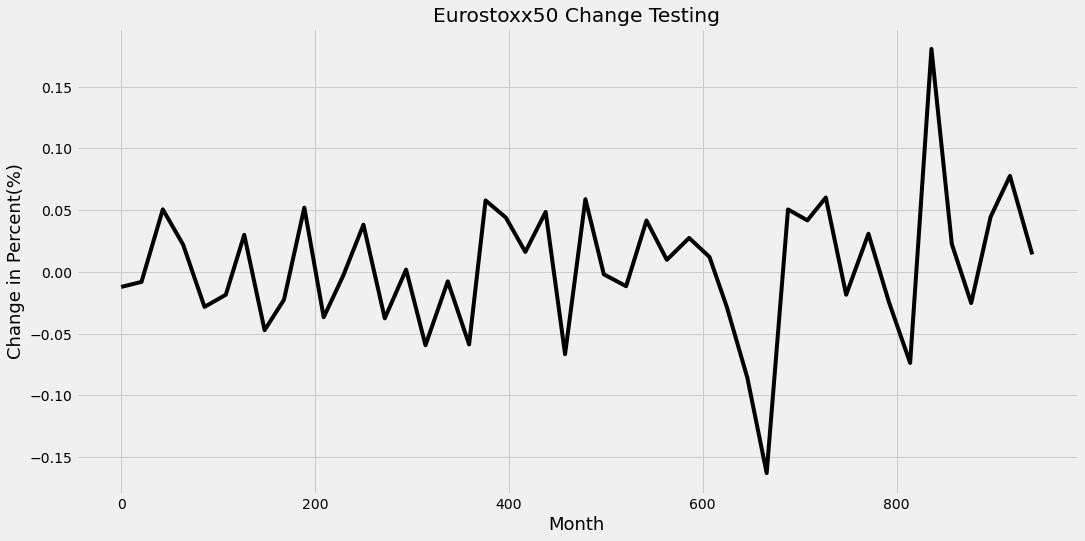

In [14]:
plt.figure(figsize=(16,8))
plt.title('Eurostoxx50 Change Testing')
plt.plot(monthlyChange_testing['mChange'], color = 'black')
plt.xlabel('Month',fontsize=18)
plt.ylabel('Change in Percent(%)',fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()

# split the corr into independend and dependend 

split the data corresponding to dates into training and testing
X -> independend
Y -> dependend

In [15]:
y_train = monthlyChange['mChange']
X_train = monthlyChange[['Month']]

In [16]:
y_test = monthlyChange_testing['mChange']
X_test = monthlyChange_testing[['Month']]

# implementing and testing models


## linear regression


In [17]:
lr_model=LinearRegression()
lr_model.fit(X_train,y_train)

LinearRegression()

In [18]:
y_pred=lr_model.predict(X_test)

push values into new array to reset index

-> index before was inconsistent due to dropping duplicates, has to be consistant in order to compare values w/ predictions


In [19]:
testing = y_test.values

In [20]:
from sklearn import model_selection
from sklearn.model_selection import KFold
kfold = model_selection.KFold(n_splits=20)
results_kfold = model_selection.cross_val_score(lr_model, X_test, testing.astype('int'), cv=kfold)
print("Accuracy: ", results_kfold.mean()*100)
print(results_kfold)

Accuracy:  100.0
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


## K-Nearest-Neighbor

In [21]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor=KNeighborsRegressor(n_neighbors = 5)
knn_model=knn_regressor.fit(X_train,y_train)
y_knn_pred=knn_model.predict(X_test)

In [22]:
knn_kfold = model_selection.KFold(n_splits=20)
results_kfold = model_selection.cross_val_score(knn_model, X_test, testing.astype('int'), cv=knn_kfold)
print("Accuracy: ", results_kfold.mean()*100)

Accuracy:  100.0


## Support-Vector-Machines

In [23]:
from sklearn.svm import SVR
svm_regressor = SVR(kernel='linear')
svm_model=svm_regressor.fit(X_train,y_train)
y_svm_pred=svm_model.predict(X_test)

## Random Forest

In [24]:
RFmodel = RandomForestRegressor()
RFmodel.fit(X_train,y_train)
confRF = RFmodel.score(X_test,testing)
confRF

-0.15708582094503254

In [25]:
predictions_RF = RFmodel.predict(X_test)

## Polynomial Features

In [26]:
# Estmate pyolnomial splines
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

polynomial_features = PolynomialFeatures(degree=5, include_bias=False)
linear_regression = LinearRegression()
pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])

pipeline.fit(X_train, y_train)
y_pred_poly = pipeline.predict(X_test)

# Evaluation (comparison and MSE)

In [27]:
from sklearn.metrics import mean_squared_error 

## Linear Regression

In [28]:
lr_mse=mean_squared_error(testing,y_pred)
print('Linear Model mean square error',lr_mse)

Linear Model mean square error 0.0028876895538224286


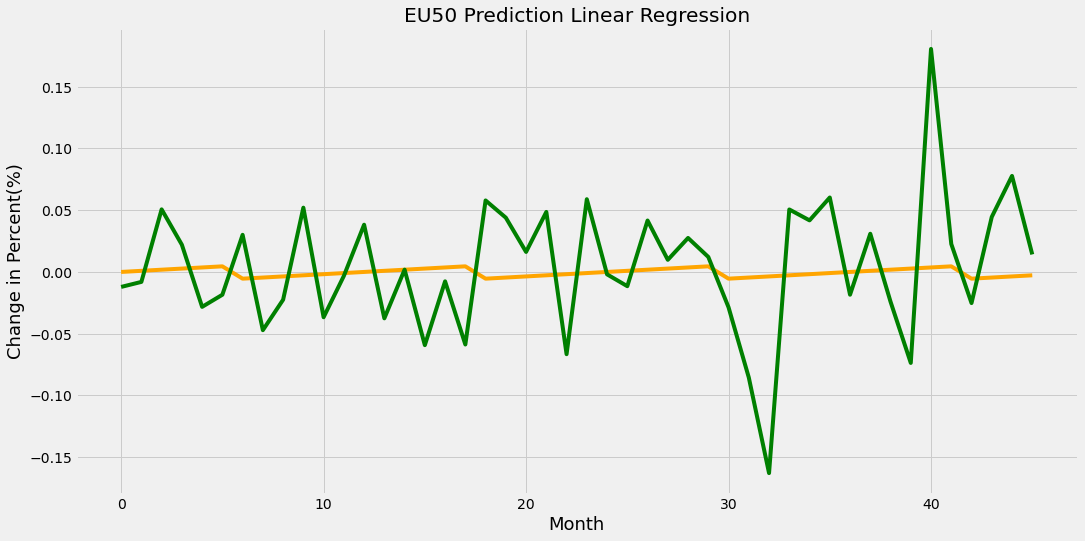

In [29]:
plt.figure(figsize=(16,8))
plt.title('EU50 Prediction Linear Regression')
plt.plot(y_pred, color = 'orange')
plt.plot(testing, color = 'green')
plt.xlabel('Month',fontsize=18)
plt.ylabel('Change in Percent(%)',fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()

## K-Nearest-Neighbor

In [30]:
knn_mse=mean_squared_error(testing,y_knn_pred)
print('KNN Model mean square error',knn_mse)

KNN Model mean square error 0.004578033092544774


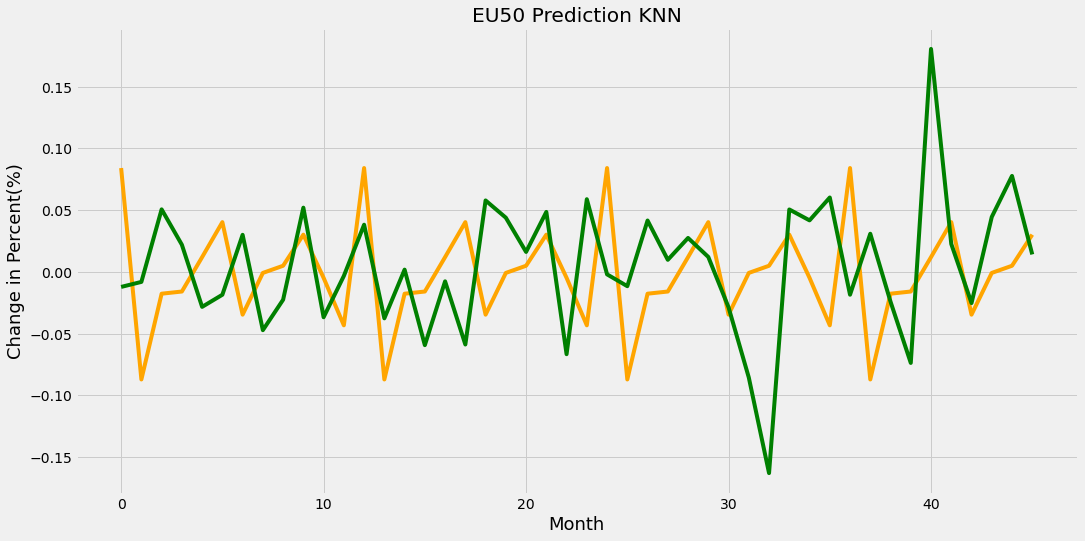

In [31]:
plt.figure(figsize=(16,8))
plt.title('EU50 Prediction KNN')
plt.plot(y_knn_pred, color = 'orange')
plt.plot(testing, color = 'green')
plt.xlabel('Month',fontsize=18)
plt.ylabel('Change in Percent(%)',fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()

## Support-Vector-Machines

In [32]:
svm_mse=mean_squared_error(testing,y_svm_pred)
print('SVM Model mean square error',svm_mse)

SVM Model mean square error 0.0031922584068108956


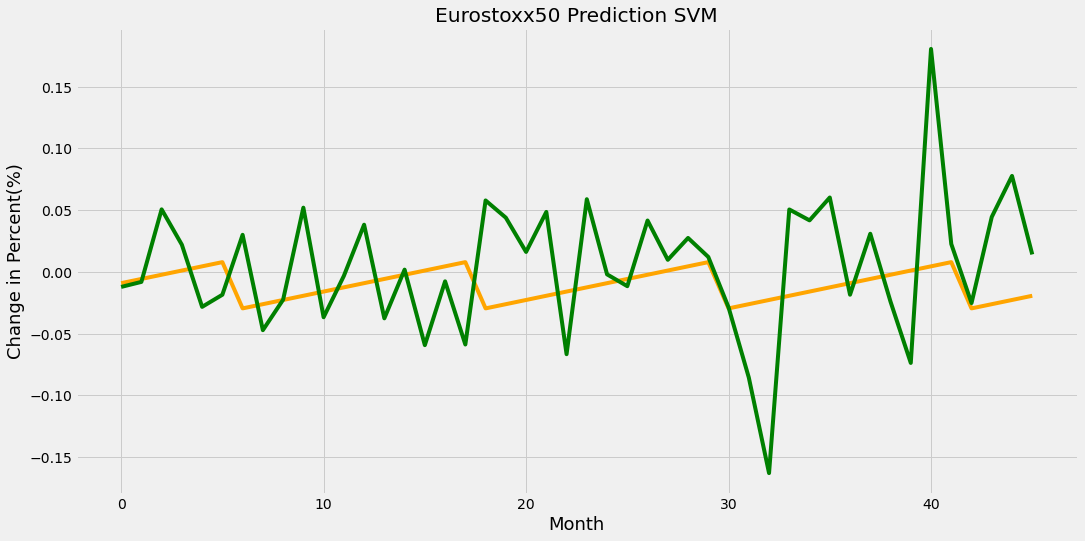

In [33]:
plt.figure(figsize=(16,8))
plt.title('Eurostoxx50 Prediction SVM')
plt.plot(y_svm_pred, color = 'orange')
plt.plot(testing, color = 'green')
plt.xlabel('Month',fontsize=18)
plt.ylabel('Change in Percent(%)',fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()

## Random Forest

In [34]:
RF_mse=mean_squared_error(testing,predictions_RF)
print('Random Forest Model mean square error',RF_mse)

Random Forest Model mean square error 0.0033163831227997426


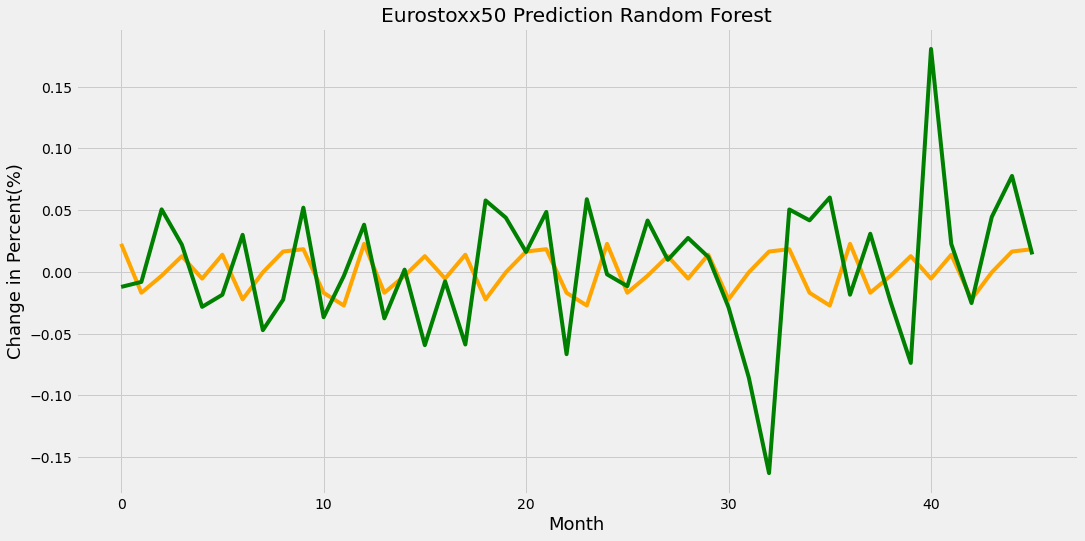

In [35]:
plt.figure(figsize=(16,8))
plt.title('Eurostoxx50 Prediction Random Forest')
plt.plot(predictions_RF, color = 'orange')
plt.plot(testing, color = 'green')
plt.xlabel('Month',fontsize=18)
plt.ylabel('Change in Percent(%)',fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()

## Polynomial Features

In [36]:
print("Mean Squared Error:", mean_squared_error(testing, y_pred_poly))

Mean Squared Error: 0.0030989631473464295


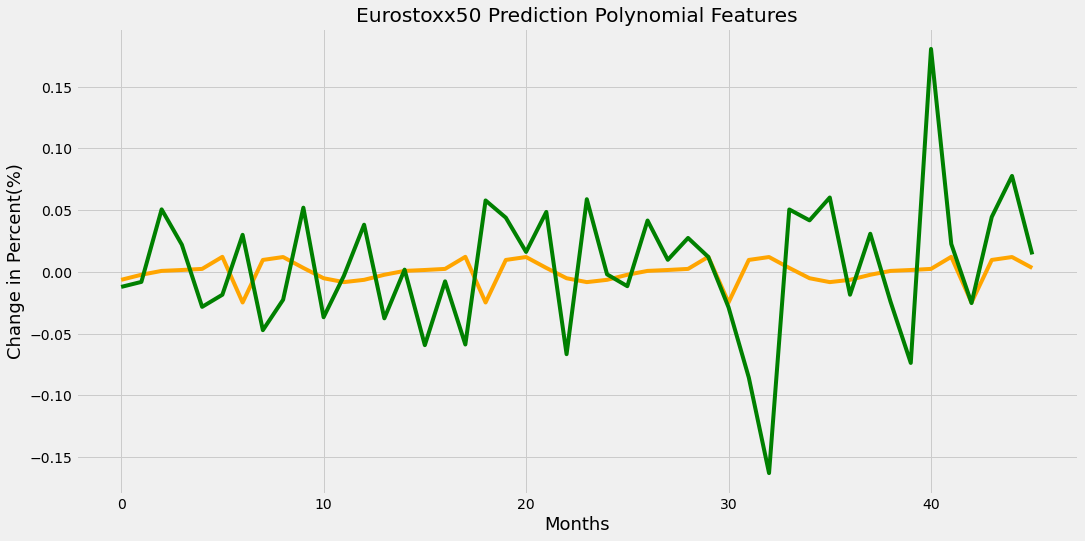

In [37]:
plt.figure(figsize=(16,8))
plt.title('Eurostoxx50 Prediction Polynomial Features')
plt.plot(y_pred_poly, color = 'orange')
plt.plot(testing, color = 'green')
plt.xlabel('Months',fontsize=18)
plt.ylabel('Change in Percent(%)',fontsize=18)
plt.style.use('fivethirtyeight')
plt.show()